In [1]:
import scipy.fft as fft
from tqdm.notebook import tqdm

from plot import *
from maths import rmse


In [2]:
def _dft_at_time_level_and_latitude(data: np.ndarray, quantile: float = 0.75):
    yf = fft.rfft(data)[1:]
    frequencies = fft.rfftfreq(576, 1 / 0.625)[1:]
    amplitudes = np.abs(yf).astype("float16")

    cutoff_amp = np.quantile(amplitudes, quantile)
    transform = {}

    for i, freq in enumerate(frequencies):
        if (amp := amplitudes[i]) < cutoff_amp:
            continue

        transform[freq] = np.angle(yf[i]), amp

    return transform


def plot_dft_at_time_level_and_latitude(filename: str, variable: str, time: int, level: int, latitude: int, folder: str,
                                        **kwargs):
    data = load_variable_at_time_level_and_latitude(filename, variable, time, level, latitude, folder)
    data -= data.mean()

    transform = _dft_at_time_level_and_latitude(data, **kwargs)

    prediction = np.zeros((576,))
    for freq, (phase, amp) in transform.items():
        prediction += amp * np.cos(np.linspace(0, 576 / 0.625, 576) * 2 * np.pi * freq + phase) / 288

    plt.plot(np.linspace(-180, 180, 576), data, linewidth=1)
    plt.plot(np.linspace(-180, 180, 576), prediction, linestyle="dashed", linewidth=1)

    plt.title(f"{variable} ({get_units_from_variable(variable)}) at {format_latitude(latitude)}, {format_level(level)}"
              f" on {format_date(filename)} at {format_time(time)}", fontsize=8)
    plt.show()

    print(f"Frequencies: {len(transform)}")
    print(f"Original Standard Dev (m/s):  {data.std()}")
    print(f"Predicted Standard Dev (m/s): {rmse(data, prediction)}")


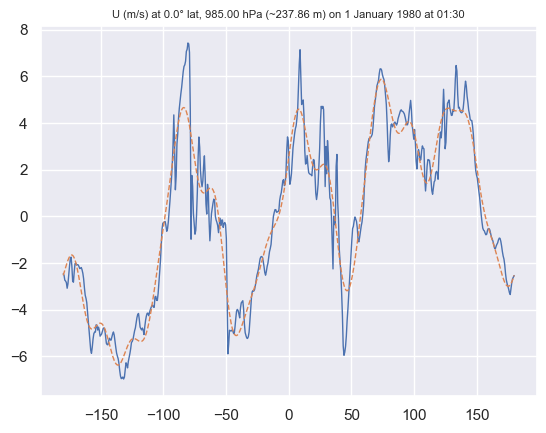

Frequencies: 11
Original Standard Dev (m/s):  3.640625
Predicted Standard Dev (m/s): 0.9927797269149637


In [3]:
plot_dft_at_time_level_and_latitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                    time=0, level=71, latitude=180, folder="compressed/wind",
                                    quantile=0.965)

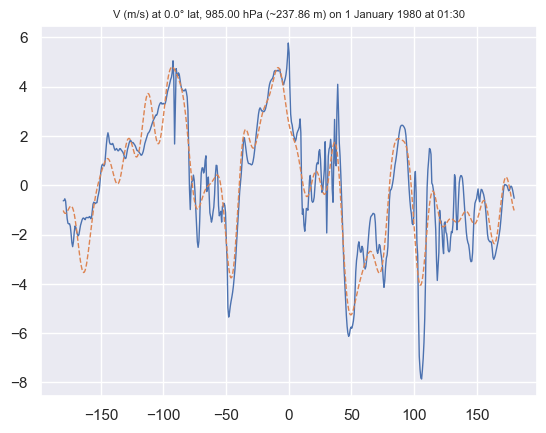

Frequencies: 11
Original Standard Dev (m/s):  2.53125
Predicted Standard Dev (m/s): 1.058684348427054


In [4]:
plot_dft_at_time_level_and_latitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                                    time=0, level=71, latitude=180, folder="compressed/wind",
                                    quantile=0.965)

In [3]:
def plot_dft_at_time_and_level(filename: str, variable: str, time: int, level: int, folder: str, **kwargs):
    data = load_variable_at_time_and_level(filename, variable, time, level, folder)

    prediction = np.zeros((361, 576))

    worst_deviation = 0
    worst_lat = 0

    for lat in tqdm(range(361)):
        subdata = data[lat]
        mean = subdata.mean()
        subdata -= mean
        transform = _dft_at_time_level_and_latitude(subdata, **kwargs)

        pred = np.zeros((576,))
        for freq, (phase, amp) in transform.items():
            pred += amp * np.cos(np.linspace(0, 576 / 0.625, 576) * 2 * np.pi * freq + phase) / 288

        if (dev := rmse(subdata, pred)) > worst_deviation:
            worst_deviation = dev
            worst_lat = lat

        subdata += mean
        pred += mean
        prediction[lat] = pred

    _, ax1, ax2 = create_1x2_plot(f"{variable} ({get_units_from_variable(variable)}) at {format_level(level)}"
                                  f" on {format_date(filename)} at {format_time(time)}", sharey=True)
    ax1.imshow(data, cmap="viridis", origin="lower")
    ax2.imshow(prediction, cmap="viridis", origin="lower")

    _, ax1, ax2 = create_1x2_plot(f"Absolute Error ({get_units_from_variable(variable)}) at {format_level(level)}"
                                  f" on {format_date(filename)} at {format_time(time)}")
    ax1.imshow(np.abs(prediction - data), cmap="hot", origin="lower")
    ax2.plot(np.linspace(-180, 180, 576), data[worst_lat], linewidth=1)
    ax2.plot(np.linspace(-180, 180, 576), prediction[worst_lat], linestyle="dashed", linewidth=1)

    plt.show()

    print(f"Original Stdev: {data.astype('float32').std()} m/s")
    print(f"Predicted RMSE: {rmse(data, prediction)} m/s")
    print(f"Frequencies/latitude: {len(transform)}")
    print(f"Size: {len(transform) * 361 * 5 / 1024} kB")
    print()
    print(f"Stdev at Worst: {data[worst_lat].astype('float32').std()} m/s")
    print(f"Worst RMSE: {worst_deviation} m/s")


In [5]:
%matplotlib notebook

plot_dft_at_time_and_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                           time=0, level=71, folder="compressed/wind",
                           quantile=0.965)


  0%|          | 0/361 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original Stdev: 5.884542942047119 m/s
Predicted RMSE: 1.630530210417394 m/s
Frequencies/latitude: 11
Size: 19.3896484375 kB

Stdev at Worst: 5.563652515411377 m/s
Worst RMSE: 2.8573050413374257 m/s


In [6]:
%matplotlib notebook

plot_dft_at_time_and_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                           time=0, level=71, folder="compressed/wind",
                           quantile=0.965)

  0%|          | 0/361 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original Stdev: 5.0945658683776855 m/s
Predicted RMSE: 1.9405576992933267 m/s
Frequencies/latitude: 11
Size: 19.3896484375 kB

Stdev at Worst: 6.400732517242432 m/s
Worst RMSE: 3.384549038106958 m/s


In [7]:
def plot_dft_at_time(filename: str, variable: str, time: int, folder: str, **kwargs):
    data = load_variable_at_time(filename, variable, time, folder)
    prediction = np.zeros((72, 361, 576))

    worst_deviation_ratio = 0
    worst_deviation = 0
    worst_deviation_std = 0

    deviations = []

    for lev in tqdm(range(72)):
        for lat in range(361):
            subdata = data[lev][lat]
            mean = subdata.mean()
            subdata -= mean
            transform = _dft_at_time_level_and_latitude(subdata, **kwargs)

            pred = np.zeros((576,))
            for freq, (phase, amp) in transform.items():
                pred += amp * np.cos(np.linspace(0, 576 / 0.625, 576) * 2 * np.pi * freq + phase) / 288

            subdata += mean
            pred += mean
            if (ratio := (dev := rmse(subdata, pred)) / subdata.astype("float32").std()) > worst_deviation_ratio:
                worst_deviation_ratio = ratio
                worst_deviation = dev
                worst_deviation_std = subdata.astype("float32").std()

            deviations.append(dev)

            prediction[lev][lat] = pred

    plot_histogram([{"data": deviations}], "Distribution of Prediction RMSE (m/s)", bins=100)

    print(f"Original Stdev: {(data.astype('float32')).std()} m/s")
    print(f"Predicted RMSE: {rmse(data, prediction)} m/s")
    print(f"Size: {len(transform) * 361 * 72 * 4 / (1024 ** 2)} mB")
    print()
    print(f"Stdev at Worst: {worst_deviation_std} m/s")
    print(f"Worst RMSE: {worst_deviation} m/s")


In [38]:
%matplotlib notebook

plot_dft_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                 time=0, folder="compressed/wind",
                 quantile=0.965)

  0%|          | 0/72 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Original Stdev: 28.18543815612793 m/s
Predicted RMSE: 1.5336775651078645 m/s
Size: 1.090667724609375 mB

Stdev at Worst: 4.466701984405518 m/s
Worst RMSE: 2.6110967018071056 m/s


In [9]:
def compare_dft_at_time_vs_quantile(filename: str, variable: str, time: int, folder: str, quantiles: list[float]):
    data = load_variable_at_time(filename, variable, time, folder)
    data_dict = []

    for quant in tqdm(quantiles):
        prediction = np.zeros((72, 361, 576))

        deviations = []

        for lev in range(72):
            for lat in range(361):
                subdata = data[lev][lat]
                subdata -= subdata.mean()
                transform = _dft_at_time_level_and_latitude(subdata, quantile=quant)

                pred = np.zeros((576,))
                for freq, (phase, amp) in transform.items():
                    pred += amp * np.cos(np.linspace(0, 576 / 0.625, 576) * 2 * np.pi * freq + phase) / 288

                deviations.append(rmse(subdata, pred))
                prediction[lev][lat] = pred

        data_dict.append({"data": deviations, "label": f"{quant * 100:0>1}%"})

    fig, ax11, ax12, ax21, ax22 = create_2x2_plot("Distribution of Prediction RMSE (m/s)", sharex=True, sharey=True)

    plt.sca(ax11)
    plot_histogram([data_dict[0]], "", bins=50)
    plt.sca(ax12)
    plot_histogram([data_dict[1]], "", bins=50)
    plt.sca(ax21)
    plot_histogram([data_dict[2]], "", bins=50)
    plt.sca(ax22)
    plot_histogram([data_dict[3]], "", bins=50)


In [ ]:
%matplotlib notebook

compare_dft_at_time_vs_quantile("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                time=0, folder="compressed/wind",
                                quantiles=[0.95, 0.965, 0.975, 0.99])


In [ ]:
%matplotlib notebook

compare_dft_at_time_vs_quantile("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                                time=0, folder="compressed/wind",
                                quantiles=[0.95, 0.965, 0.975, 0.99])
